# Wind Turbine Accidents: A Data Mining Study

### Imports

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats
import scipy.special as sp
from scipy.stats import norm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Dense

In [2]:
raw_dataset = pd.read_csv('News.Database.csv')

In [3]:
pd.set_option('display.max_columns', None)

raw_dataset.head()

,Accident No,Accident type,Site/area\n,Country\n,Details\n,Web reference/link\n,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW),Offshore,During Construction,FULL-DATE,Outcome,Death,Fire,Injury,Mechanical,Structural Break,Transport Accident,Component,Cause,CauseCategory,Source Database,Source of the News,Title of the article
0,1.0,Wind,Tjaereborg,Denmark,Damage to all 3 blades,http://www.modernpowersystems.com/story.asp?st...,2002,11,4,Vestas 2000 KW,Vestas,2000,19000,1,0,"April 11, 2002",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Blade,Human (interference in control systems),Human,LexisNexis,Major World Publications,Bending with the wind
1,2.0,Wind,Jiangsu,China,5 died & 4 injured workers,http://www.chinadaily.com.cn/china/2012-03/11/...,2012,3,10,UNKNOWN,UNKNOWN,UNKNOWN,5000,1,1,"October 3, 2012",Structural break,1.0,0.0,1.0,0.0,1.0,0.0,UNKNOWN,Mechanical (platform collapse at construction ...,Mechanical,LexisNexis,Modern Power System,Death toll in China construction site accident...
2,3.0,Wind,Ireland,UK,The turbine came loose after bolts attaching i...,http://www.modernpowersystems.com/story.asp?st...,2009,1,UNKNOWN,Enercon 2000 KW,Enercon,2000,4000,0,0,UNKNOWN,Structural break,0.0,0.0,0.0,1.0,1.0,0.0,Bolt,Mechanical (material fatigue),Mechanical,LexisNexis,The Sunday Telegraph,ET 'not to blame'
3,4.0,Wind,"Berwickshire, Scotland",UK,A 30m turbine near Coldingham was deliberately...,http://www.windbyte.co.uk/safety.html,2011,12,7,Hannevind 22 KW,Hannevind,22,UNKNOWN,0,0,"December 7, 2011",Mechanical,0.0,0.0,0.0,1.0,0.0,0.0,Tower,Mechanical ( blade system failure),Mechanical,Google,windbyte.co.uk,Wind turbine safety
4,5.0,Wind,Ohio,USA,The fallen wind turbine was supplying power to...,http://www.vindy.com/news/2011/apr/11/wind-tur...,2011,4,10,Proven 15 KW,Proven,15,45,0,0,"April 11, 2011",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Tower,UNKNOWN,UNKNOWN,LexisNexis,vindy.com,Wind turbine failure western reserve high scho...


In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Accident No            273 non-null    float64
 1   Accident type          273 non-null    object 
 2   Site/area
             273 non-null    object 
 3   Country
               273 non-null    object 
 4   Details
               273 non-null    object 
 5   Web reference/link
    273 non-null    object 
 6   Year                   273 non-null    object 
 7   Month                  273 non-null    object 
 8   Day                    273 non-null    object 
 9   Turbine Type           273 non-null    object 
 10  Manufacturer           273 non-null    object 
 11  Power of Turbine (KW)  273 non-null    object 
 12  PowerOfWindFarm (KW)   273 non-null    object 
 13  Offshore               83 non-null     object 
 14  During Construction    83 non-null     object 
 15  FULL-D

In [3]:
raw_dataset['Afectted Humans'] =raw_dataset['Death'] + raw_dataset['Injury']
raw_dataset['Afectted Humans'] = raw_dataset['Afectted Humans'].map({2.0: 1.0, 1.0:1.0,0.0:0.0})

raw_dataset['Affected System/Equipment'] =raw_dataset['Fire'] + raw_dataset['Structural Break'] + raw_dataset['Transport Accident']
raw_dataset['Affected System/Equipment'] = raw_dataset['Affected System/Equipment'].map({3.0:1.0,2.0: 1.0, 1.0:1.0,0.0:0.0})

raw_dataset['Event Ocurrence'] = 'UNKNOWN'
raw_dataset = raw_dataset[raw_dataset['Details\n'].notna()]
for a, b in raw_dataset.iterrows():
    if "transportation" in b["Details\n"] or b["Transport Accident"] == 1:
        raw_dataset["Event Ocurrence"][a] = "transportation"
    elif "construction" in b["Details\n"] or b["During Construction"] == 1:
        raw_dataset["Event Ocurrence"][a] = "construction"
    elif "operation" in b["Details\n"]:
        raw_dataset["Event Ocurrence"][a] = "operation"
    elif "maintenance" in b["Details\n"]:
        raw_dataset["Event Ocurrence"][a] = "maintenance"
        
raw_dataset.columns = ['Onshore/Offshore' if x=='Offshore' else x for x in raw_dataset.columns]
raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].map({"1":"Offshore","0":"Onshore"})

raw_dataset = raw_dataset.drop('Details\n', axis=1)
raw_dataset = raw_dataset.drop('Accident No', axis=1)
raw_dataset = raw_dataset.drop('Accident type', axis=1) 
raw_dataset = raw_dataset.drop('Source Database', axis=1)
raw_dataset = raw_dataset.drop('Source of the News', axis=1)
raw_dataset = raw_dataset.drop('Title of the article', axis=1)
raw_dataset = raw_dataset.drop('Web reference/link\n', axis=1)
raw_dataset = raw_dataset.drop('Outcome', axis=1)
raw_dataset = raw_dataset.drop('Cause', axis=1)
#raw_dataset = raw_dataset.drop('CauseCategory', axis=1)
raw_dataset = raw_dataset.drop('FULL-DATE', axis=1)
raw_dataset = raw_dataset.drop('Day', axis=1)
raw_dataset = raw_dataset.drop('Month', axis=1)
raw_dataset = raw_dataset.drop('Year', axis=1)


raw_dataset.columns = ['Site/area' if x=='Site/area\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Country' if x=='Country\n' else x for x in raw_dataset.columns]
#raw_dataset.columns = ['Details' if x=='Details\n' else x for x in raw_dataset.columns]
#raw_dataset.columns = ['Web reference/link' if x=='Web reference/link\n' else x for x in raw_dataset.columns]

raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].fillna("0")
raw_dataset['During Construction'] = raw_dataset['During Construction'].fillna("0")

df = raw_dataset.copy()

df.drop(df[df.isnull().sum(axis=1) > 7].index, inplace=True)

yDeath = df['Death']
yInjury = df['Injury']

df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

<ipython-input-3-59c99ec6f492>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["Event Ocurrence"][a] = "transportation"
<ipython-input-3-59c99ec6f492>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["Event Ocurrence"][a] = "maintenance"
<ipython-input-3-59c99ec6f492>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["Event Ocurrence"][a] = "construction"
<ipython-input-3-59c99ec6f492>:15: Setting

In [6]:
enc = OrdinalEncoder()
enc.fit(df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component", "Event Ocurrence"]])
df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component", "Event Ocurrence"]] = enc.transform(df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component", "Event Ocurrence"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

In [7]:
X_trainD, X_testD, y_trainD, y_testD = train_test_split(df, yDeath, test_size=0.33, random_state=42)
X_trainI, X_testI, y_trainI, y_testI = train_test_split(df, yInjury, test_size=0.33, random_state=42)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site/area                  273 non-null    float64
 1   Country                    273 non-null    float64
 2   Turbine Type               273 non-null    float64
 3   Manufacturer               273 non-null    float64
 4   Power of Turbine (KW)      273 non-null    float64
 5   PowerOfWindFarm (KW)       273 non-null    float64
 6   Onshore/Offshore           273 non-null    float64
 7   During Construction        273 non-null    float64
 8   Fire                       273 non-null    float64
 9   Mechanical                 273 non-null    float64
 10  Structural Break           273 non-null    float64
 11  Transport Accident         273 non-null    float64
 12  Component                  273 non-null    float64
 13  CauseCategory              273 non-null    float64

<ipython-input-16-96df2b3ca568>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cross = cross.drop("UNKNOWN", 0)
<ipython-input-16-96df2b3ca568>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cross = cross.drop("UNKNOWN", 1)


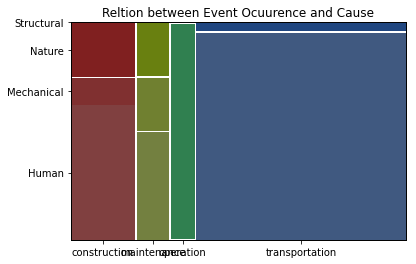

In [16]:
plotdf = pd.DataFrame(columns=[])

plotdf["Event Ocurrence"] = df["Event Ocurrence"]
plotdf["CauseCategory"] = df["CauseCategory"]
plotdf["Death"] = yDeath
plotdf["Injury"] = yInjury
#plotdf = plotdf[plotdf["Event Ocurrence"] != 'UNKNOWN']
#plotdf = plotdf[plotdf["CauseCategory"] != 'UNKNOWN']

cross = pd.crosstab(plotdf["Event Ocurrence"], plotdf["CauseCategory"])
crossD = pd.crosstab(plotdf["Event Ocurrence"], plotdf["Death"])
crossI = pd.crosstab(plotdf["Event Ocurrence"], plotdf["Injury"])
crossDD = pd.crosstab(plotdf["CauseCategory"], plotdf["Death"])
crossII = pd.crosstab(plotdf["CauseCategory"], plotdf["Injury"])

cross = cross.drop("UNKNOWN", 0)
cross = cross.drop("UNKNOWN", 1)

labels = lambda k: ""
res = mosaic(cross.stack(), labelizer = labels, title="Reltion between Event Ocuurence and Cause")

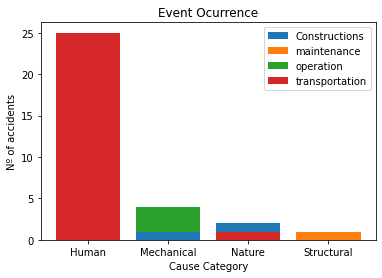

In [53]:
grupos = plotdf["CauseCategory"].unique().tolist()
grupos.remove('UNKNOWN')
indice = np.arange(len(grupos))

## Se crean las primeras barras
plt.bar(indice, cross.iloc[[0]].values.flatten().tolist(), label='Constructions')
plt.bar(indice, cross.iloc[[1]].values.flatten().tolist(), label='maintenance',  bottom=cross.iloc[[0]].values.flatten().tolist())
plt.bar(indice, cross.iloc[[2]].values.flatten().tolist(), label='operation',  bottom=cross.iloc[[1]].values.flatten().tolist())
plt.bar(indice, cross.iloc[[3]].values.flatten().tolist(), label='transportation',  bottom=cross.iloc[[2]].values.flatten().tolist())
 

plt.xticks(indice, grupos)
plt.ylabel("Nº of accidents")
plt.xlabel("Cause Category")
plt.title('Event Ocurrence')
plt.legend()
 
plt.show()

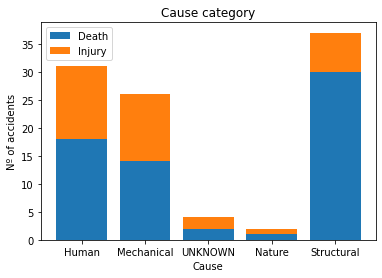

In [14]:
grupos = plotdf["CauseCategory"].unique()
indice = np.arange(len(grupos))
 
## Se crean las primeras barras
plt.bar(indice, crossDD[1], label='Death')
 
## Se crean las segundas barras y se apilan sobre las primeras
plt.bar(indice, crossII[1], label='Injury',  bottom=crossDD[1])
 
plt.xticks(indice, grupos)
plt.ylabel("Nº of accidents")
plt.xlabel("Cause")
plt.title('Cause category')
plt.legend()
 
plt.show()

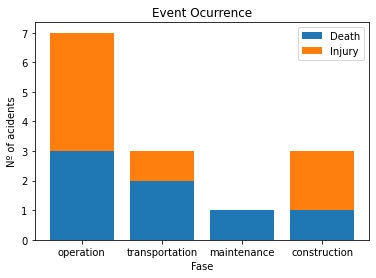

In [156]:
grupos = plotdf["Event Ocurrence"].unique() 
grupos = np.delete(grupos , [0])
indice = np.arange(len(grupos))
 
## Se crean las primeras barras
plt.bar(indice, crossD[1][1:], label='Death')
 
## Se crean las segundas barras y se apilan sobre las primeras
plt.bar(indice, crossI[1][1:], label='Injury',  bottom=crossD[1][1:])
 
plt.xticks(indice, grupos)
plt.ylabel("Nº of acidents")
plt.xlabel("Fase")
plt.title('Event Ocurrence')
plt.legend()
 
plt.show()

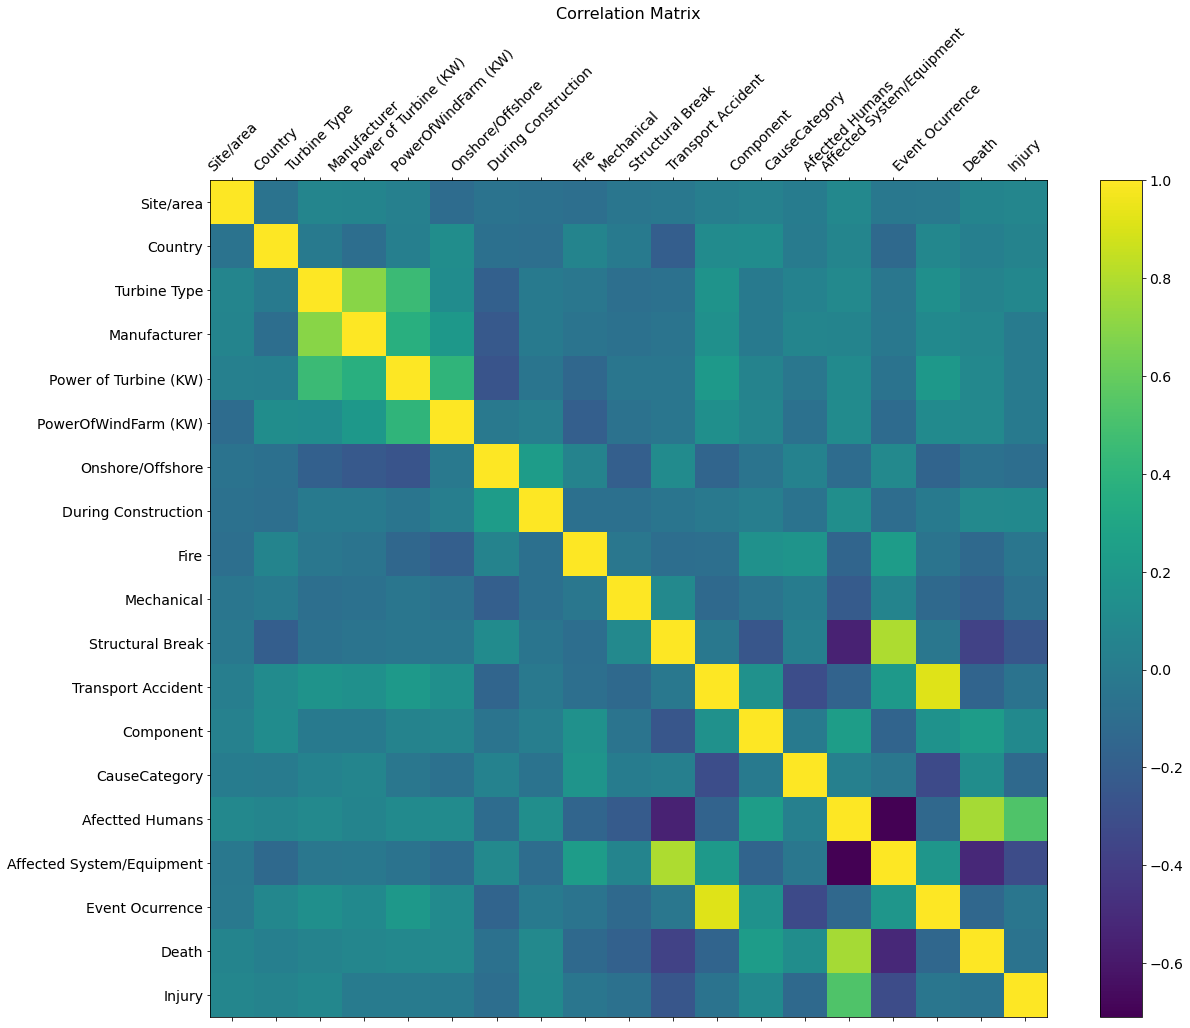

In [70]:
df_corrr = df
df_corrr["Death"] = yDeath
df_corrr["Injury"] = yInjury

cr_mtx = df_corrr.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(cr_mtx, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [71]:
upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))
cr_mtx = upper.fillna(0)

<ipython-input-71-e56867fb7b22>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))


In [72]:
lst = list(cr_mtx.columns.values)
c = []
for i in lst:
    for j in lst:
        #if (i != j and (cr_mtx[i][j] >= 0.2 or cr_mtx[i][j] <= -0.2)) and ((df[i].nunique() > 2 or (df[i].nunique() == 2 and (i == "Death" or i == "Injury" ))) and (df[j].nunique() > 2 or (df[j].nunique() == 2 and (j == "Death" or j == "Injury" )))):
        if (i != j and (cr_mtx[i][j] >= 0.2 or cr_mtx[i][j] <= -0.2)):
            c.append({i,j})

c            

[{'Manufacturer', 'Turbine Type'},
 {'Power of Turbine (KW)', 'Turbine Type'},
 {'Manufacturer', 'Power of Turbine (KW)'},
 {'Manufacturer', 'PowerOfWindFarm (KW)'},
 {'Power of Turbine (KW)', 'PowerOfWindFarm (KW)'},
 {'Manufacturer', 'Onshore/Offshore'},
 {'Onshore/Offshore', 'Power of Turbine (KW)'},
 {'During Construction', 'Onshore/Offshore'},
 {'Power of Turbine (KW)', 'Transport Accident'},
 {'Component', 'Structural Break'},
 {'CauseCategory', 'Transport Accident'},
 {'Afectted Humans', 'Mechanical'},
 {'Afectted Humans', 'Structural Break'},
 {'Afectted Humans', 'Component'},
 {'Affected System/Equipment', 'Fire'},
 {'Affected System/Equipment', 'Structural Break'},
 {'Affected System/Equipment', 'Transport Accident'},
 {'Afectted Humans', 'Affected System/Equipment'},
 {'Event Ocurrence', 'Power of Turbine (KW)'},
 {'Event Ocurrence', 'Transport Accident'},
 {'CauseCategory', 'Event Ocurrence'},
 {'Death', 'Structural Break'},
 {'Component', 'Death'},
 {'Afectted Humans', 'De

In [73]:
StatisticalTest = pd.DataFrame(columns=['Test No', 'Attribute1','Attribute2', 'Correlation', 'Test Performed' ,'p-Value', 'Result'])

for x in c :
    #print(x.pop() + "  " + x.pop())
    a = x.pop()
    b =x.pop()
    if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
        # Kolmogorov-Smirnov test
        res = stats.ks_2samp(df[a], df[b], alternative='less')
        if res[1] > 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [len(StatisticalTest) , a , b , cr_mtx[a][b], "Kolmogorov-Smirnov  Test" , res[1], ok]
        
    elif raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.float64 :
        
        dfDropNa = df.dropna()
        
        res = stats.chi2_contingency(pd.crosstab(dfDropNa[a], dfDropNa[b], margins = False))
        if res[1] > 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [len(StatisticalTest) , a , b , cr_mtx[a][b], "Chi Square Pearson Test" , res[1], ok]
        
    elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):
        dfDropNa = df.dropna()     
        
        res = stats.shapiro(dfDropNa[[a, b]])
        if res[1] > 0.05 : 
            res1 = stats.ttest_ind(dfDropNa[a], dfDropNa[b])
            if res1[1] > 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [len(StatisticalTest) , a , b , cr_mtx[a][b], "T-Test" , res[1], ok]
        else :
            res1 = stats.kruskal(dfDropNa[a], dfDropNa[b])
            if res1[1] > 0.000000000000000000000005 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [len(StatisticalTest) , a , b , cr_mtx[a][b], "Kruskal-Wallis Test" , res[1], ok]
    
StatisticalTest.sort_values('p-Value',ascending=[False] )

<ipython-input-73-14c62075951d>:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
<ipython-input-73-14c62075951d>:27: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):


,Test No,Attribute1,Attribute2,Correlation,Test Performed,p-Value,Result
6,6,Onshore/Offshore,Power of Turbine (KW),-0.264821,Kolmogorov-Smirnov Test,1.000000e+00,-
3,3,Manufacturer,PowerOfWindFarm (KW),0.000000,Kolmogorov-Smirnov Test,8.766588e-01,-
1,1,Turbine Type,Power of Turbine (KW),0.000000,Kolmogorov-Smirnov Test,3.473741e-01,-
0,0,Turbine Type,Manufacturer,0.000000,Kolmogorov-Smirnov Test,1.213906e-01,-
2,2,Manufacturer,Power of Turbine (KW),0.000000,Kolmogorov-Smirnov Test,4.592531e-02,+
16,16,Transport Accident,Affected System/Equipment,0.000000,Chi Square Pearson Test,8.243929e-04,+
11,11,Afectted Humans,Mechanical,-0.221415,Chi Square Pearson Test,5.341658e-04,+
4,4,PowerOfWindFarm (KW),Power of Turbine (KW),0.410873,Kolmogorov-Smirnov Test,4.206825e-04,+
14,14,Fire,Affected System/Equipment,0.000000,Chi Square Pearson Test,2.113838e-04,+
25,25,Injury,Structural Break,-0.249926,Chi Square Pearson Test,8.002098e-05,+


In [13]:
RankingD = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yDeath)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingD = RankingD.append(row, ignore_index= True)
    

RankingD.sort_values('Information Gain', ascending=[False])
#RankingD.sort_index()

,Attribute,Values,Information Gain
17,Affected System/Equipment,52,0.469388
13,Structural Break,79,0.373016
12,Mechanical,177,0.265560
14,Transport Accident,182,0.260163
11,Fire,181,0.255144
19,Injury,185,0.241803
9,Onshore/Offshore,157,0.237456
10,During Construction,201,0.225265
0,Site/area,9,0.186479
2,Year,12,0.141832


In [14]:
dfD = df[yDeath == 0]
dfD = dfD[[RankingD['Attribute'].iloc[0] , RankingD['Attribute'].iloc[1] , RankingD['Attribute'].iloc[2]
           , RankingD['Attribute'].iloc[3] , RankingD['Attribute'].iloc[4]]]
dfD.rank()


,Site/area,Country,Year,Month,Day
0,176.0,29.0,33.5,51.5,142.5
2,74.5,108.0,120.5,13.5,187.5
3,11.0,108.0,149.0,73.5,154.0
4,122.0,170.0,149.0,132.0,12.0
5,198.0,170.0,92.5,34.0,87.5
...,...,...,...,...,...
266,10.0,108.0,92.5,162.5,187.5
267,171.0,170.0,92.5,162.5,187.5
268,33.0,15.0,92.5,176.0,187.5
271,66.0,170.0,92.5,195.0,109.5


In [15]:
RankingI = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yInjury)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingI = RankingI.append(row, ignore_index= True)
    

RankingI.sort_values('Information Gain', ascending=[False])

,Attribute,Values,Information Gain
17,Affected System/Equipment,68,0.252747
13,Structural Break,93,0.211864
4,Day,15,0.211581
3,Month,30,0.180183
0,Site/area,4,0.179807
7,Power of Turbine (KW),24,0.143329
9,Onshore/Offshore,169,0.142189
1,Country,26,0.140021
12,Mechanical,209,0.136364
18,Death,185,0.135514


In [34]:
#Split the data into test and train
df = raw_dataset.copy()
df = df.dropna()
yDeath = df['Death']
yInjury = df['Injury']
df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

enc = OrdinalEncoder()
enc.fit(df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component"]])
df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component"]] = enc.transform(df[["CauseCategory", "Site/area","Country", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "Component"]])

for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

X_trainD, X_testD, y_trainD, y_testD = train_test_split(df, yDeath, test_size=0.33, random_state=42)
X_trainI, X_testI, y_trainI, y_testI = train_test_split(df, yInjury, test_size=0.33, random_state=42)

KeyError: "['Site/area', 'Country', 'Onshore/Offshore'] not in index"

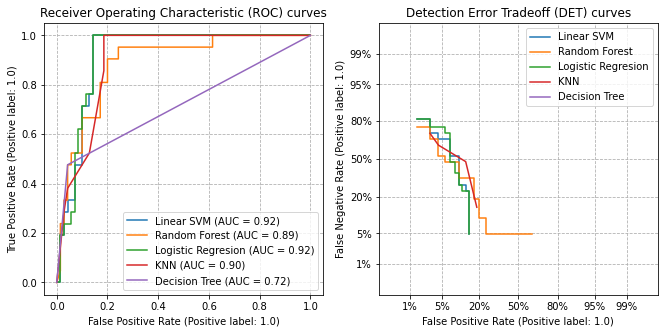

,Classifier,CA,AUC
0,Linear SVM,0.890110,0.928571
2,Logistic Regresion,0.835165,0.809524
1,Random Forest,0.835165,0.726190
4,Decision Tree,0.846154,0.716667
3,KNN,0.791209,0.697619


In [41]:
ClassifiersD = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainD, y_trainD)
    score = accuracy_score(y_testD, clf.predict(X_testD))
    roc = roc_auc_score(y_testD, clf.predict(X_testD))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersD = ClassifiersD.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersD.sort_values('AUC',ascending=[False])

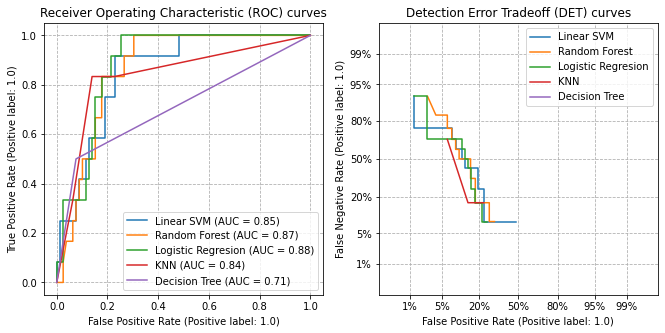

,Classifier,CA,AUC
4,Decision Tree,0.868132,0.712025
3,KNN,0.857143,0.635021
2,Logistic Regresion,0.879121,0.612342
0,Linear SVM,0.846154,0.593354
1,Random Forest,0.857143,0.493671


In [42]:
ClassifiersI = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainI, y_trainI)
    score = accuracy_score(y_testI, clf.predict(X_testI))
    roc = roc_auc_score(y_testI, clf.predict(X_testI))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersI = ClassifiersI.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersI.sort_values('AUC',ascending=[False])

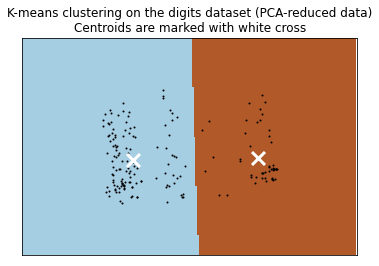

In [43]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)
labels_kmeans = kmeans.labels_

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

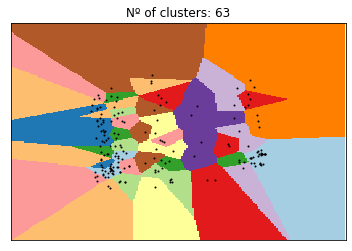

In [44]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.02, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(reduced_data)
labels_meanshift = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels_meanshift)
n_clusters_ = len(labels_unique)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = ms.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

plt.title(
    "Nº of clusters: "+str(n_clusters_)
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Overfitting

c:\users\pablo\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


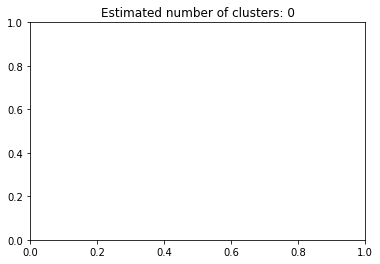

0.33776317796194116


In [45]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.2, n_samples=500)

af = AffinityPropagation(preference=-50, random_state=0).fit(reduced_data)
cluster_centers_indices = af.cluster_centers_indices_
labels_affprp = af.labels_

n_clusters_ = len(cluster_centers_indices)

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels_affprp == k
    cluster_center = reduced_data[cluster_centers_indices[k]]
    plt.plot(reduced_data[class_members, 0], reduced_data[class_members, 1], col + ".")

    for x in reduced_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()
print(metrics.silhouette_score(reduced_data, y_trainD, metric='euclidean'))

In [46]:
#print(metrics.silhouette_score(reduced_data, labels, metric='euclidean'))  overlapping
#print(davies_bouldin_score(reduced_data, labels))# (0 to 1) numero de clusters optimos, bajo mejor
#print(metrics.calinski_harabasz_score(reduced_data, labels)) #(0 to ...) clusters poco densos
#metrics.fowlkes_mallows_score(labels_kmeans, y_trainD) # calidad del clustering mas alto mejor

ClustersD = pd.DataFrame(columns=['Cluster', 'Fowlkes Mallows','Calinski Harabasz','Silhouette', 'Davies Bouldin'])

row = {'Cluster':"K-means", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_kmeans, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_kmeans, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_kmeans), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_kmeans)}
ClustersD = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Means Shift", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_meanshift, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_meanshift, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_meanshift), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_meanshift)}
ClustersD = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Affinity Propagation", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_affprp, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_affprp, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_affprp), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_affprp)}
ClustersD = ClustersD.append(row, ignore_index= True)


ClustersD

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
print("K-Means info:")
print(classification_report(y_trainD, labels_kmeans, labels=[0, 1]))
print("Mean Shift info:")
print(classification_report(y_trainD, labels_meanshift, labels=[0, 1]))
print("Affinity propagation info:")
print(classification_report(y_trainD, labels_affprp, labels=[0, 1]))

In [ ]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)
labels_kmeans = kmeans.labels_

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
(n_samples, n_features), n_digits = X_trainI.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.02, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(reduced_data)
labels_meanshift = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels_meanshift)
n_clusters_ = len(labels_unique)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = ms.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

plt.title(
    "Nº of clusters: "+str(n_clusters_)
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Overfitting

In [ ]:
(n_samples, n_features), n_digits = X_trainI.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.2, n_samples=500)

af = AffinityPropagation(preference=-50, random_state=0).fit(reduced_data)
cluster_centers_indices = af.cluster_centers_indices_
labels_affprp = af.labels_

n_clusters_ = len(cluster_centers_indices)

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels_affprp == k
    cluster_center = reduced_data[cluster_centers_indices[k]]
    plt.plot(reduced_data[class_members, 0], reduced_data[class_members, 1], col + ".")

    for x in reduced_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()
print(metrics.silhouette_score(reduced_data, y_trainD, metric='euclidean'))

In [ ]:
#print(metrics.silhouette_score(reduced_data, labels, metric='euclidean'))  overlapping
#print(davies_bouldin_score(reduced_data, labels))# (0 to 1) numero de clusters optimos, bajo mejor
#print(metrics.calinski_harabasz_score(reduced_data, labels)) #(0 to ...) clusters poco densos
#metrics.fowlkes_mallows_score(labels_kmeans, y_trainD) # calidad del clustering mas alto mejor

ClustersI = pd.DataFrame(columns=['Cluster', 'Fowlkes Mallows','Calinski Harabasz','Silhouette', 'Davies Bouldin'])

row = {'Cluster':"K-means", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_kmeans, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_kmeans, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_kmeans), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_kmeans)}
ClustersI = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Means Shift", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_meanshift, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_meanshift, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_meanshift), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_meanshift)}
ClustersI = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Affinity Propagation", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_affprp, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_affprp, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_affprp), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_affprp)}
ClustersI = ClustersD.append(row, ignore_index= True)


ClustersI

In [ ]:
print("K-Means info:")
print(classification_report(y_trainI, labels_kmeans, labels=[0, 1]))
print("Mean Shift info:")
print(classification_report(y_trainI, labels_meanshift, labels=[0, 1]))
print("Affinity propagation info:")
print(classification_report(y_trainI, labels_affprp, labels=[0, 1]))

In [47]:
rankD = pd.DataFrame(columns=['Feature', 'Rank'])


rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf.fit(X_trainD, y_trainD)

for cl in X_trainD.columns:
    row = {'Feature': cl, 'Rank': rf.feature_importances_[X_trainD.columns.get_loc(cl)]}
    rankD = rankD.append(row, ignore_index=True)

#The higher, the more important the feature. 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.
rankD.sort_values('Rank', ascending=[False])

,Feature,Rank
14,Afectted Humans,0.143069
5,PowerOfWindFarm (KW),0.114184
0,Site/area,0.108910
2,Turbine Type,0.089212
10,Structural Break,0.083687
13,CauseCategory,0.076260
15,Affected System/Equipment,0.070363
4,Power of Turbine (KW),0.067643
12,Component,0.057653
1,Country,0.053633


In [57]:
ExploratoryD = pd.DataFrame()


df_expD = raw_dataset.dropna()
df_expD = df_expD.drop(df_expD.Injury)
df_expD = df_expD.drop(df_expD[df_expD.Death == 0].index)

n = 5

ExploratoryD["Component"] = df_expD["Component"].value_counts()[:n].index.tolist()
ExploratoryD["PowerOfWindFarm (KW)"] = df_expD["PowerOfWindFarm (KW)"].value_counts()[:n].index.tolist()
ExploratoryD["Site/area"] = df_expD["Site/area"].value_counts()[:n].index.tolist()
ExploratoryD["Turbine Type"] = df_expD["Turbine Type"].value_counts()[:n].index.tolist()
ExploratoryD["CauseCategory"] = df_expD["CauseCategory"].value_counts()[:n].index.tolist()
ExploratoryD["Power of Turbine (KW)"] = df_expD["Power of Turbine (KW)"].value_counts()[:n].index.tolist()
ExploratoryD["Country"] = df_expD["Country"].value_counts()[:n].index.tolist()
ExploratoryD["Manufacturer"] = df_expD["Manufacturer"].value_counts()[:n].index.tolist()



ExploratoryD

,Component,PowerOfWindFarm (KW),Site/area,Turbine Type,CauseCategory,Power of Turbine (KW),Country,Manufacturer
0,Tower,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,USA,UNKNOWN
1,UNKNOWN,37500,"Palm Springs, California",NEG Micon 1500 KW,Human,2500,Germany,Vestas
2,Blade,44000,Minnesota,Vestas 2000 KW,Mechanical,1500,China,Siemens
3,Crane,49500 KW,Oregon,Nordex 2500 KW,Nature,2000,UK,Sinovel
4,Nacelle,5000,Iowa,Sinovel,Structural,1750,UNKNOWN,Clipper


In [6]:
rankI = pd.DataFrame(columns=['Feature', 'Rank'])


rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf.fit(X_trainI, y_trainI)

for cl in X_trainD.columns:
    row = {'Feature': cl, 'Rank': rf.feature_importances_[X_trainD.columns.get_loc(cl)]}
    rankI = rankI.append(row, ignore_index=True)

#The higher, the more important the feature. 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.
rankI.sort_values('Rank', ascending=[False])

,Feature,Rank
14,Afectted Humans,0.138340
0,Site/area,0.135173
3,Manufacturer,0.122326
15,Affected System/Equipment,0.103361
4,Power of Turbine (KW),0.087159
6,Onshore/Offshore,0.061535
5,PowerOfWindFarm (KW),0.061407
13,CauseCategory,0.049146
12,Component,0.041895
8,Fire,0.037099


In [7]:
ExploratoryI = pd.DataFrame()


df_expI = raw_dataset.dropna()
df_expI = df_expI.drop(df_expI.Death)
df_expI = df_expI.drop(df_expI[df_expI.Injury == 0].index)

n = 5
ExploratoryI["Component"] = df_expI["Component"].value_counts()[:n].index.tolist()
ExploratoryI["PowerOfWindFarm (KW)"] = df_expI["PowerOfWindFarm (KW)"].value_counts()[:n].index.tolist()
ExploratoryI["Site/area"] = df_expI["Site/area"].value_counts()[:n].index.tolist()
ExploratoryI["Turbine Type"] = df_expI["Turbine Type"].value_counts()[:n].index.tolist()
ExploratoryI["CauseCategory"] = df_expI["CauseCategory"].value_counts()[:n].index.tolist()
ExploratoryI["Power of Turbine (KW)"] = df_expI["Power of Turbine (KW)"].value_counts()[:n].index.tolist()
ExploratoryI["Country"] = df_expI["Country"].value_counts()[:n].index.tolist()
ExploratoryI["Manufacturer"] = df_expI["Manufacturer"].value_counts()[:n].index.tolist()
    
ExploratoryI

,Component,PowerOfWindFarm (KW),Site/area,Turbine Type,CauseCategory,Power of Turbine (KW),Country,Manufacturer
0,Tower,UNKNOWN,Texas,UNKNOWN,Human,UNKNOWN,USA,UNKNOWN
1,Blade,60000,Pennsylvania,Vestas 3000 KW,Mechanical,2000,UK,Vestas
2,UNKNOWN,420000,"Winnebago County, Illinois",Siemens 2300 KW,UNKNOWN,1500,Australia,Gamesa
3,Crane,420000 KW,Oregon,BWC Excel 10 KW,Nature,2300,China,Siemens
4,Nacelle,20000,Bakersfield,Kenetech 100 KW,Structural,10 KW,Greece,BWC


In [ ]:
## Sequential

model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=len(X_trainD.columns)))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = 'accuracy')
historyD = model.fit(X_trainD, y_trainD,epochs=400, batch_size=128,validation_data=(X_testD,y_testD))

In [ ]:
plt.plot(historyD.history['accuracy'], label='accuracy')
plt.plot(historyD.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossSD, test_accSD = model.evaluate(X_testD, y_testD, verbose=2)
print("Loss: "+str(test_lossSD)+" Accurracy: "+str(test_accSD))

In [ ]:
## Functional

## Creating the layers
input_layer = Input(shape=(len(X_trainD.columns),))
Layer_1 = Dense(4, activation="relu")(input_layer)
Layer_2 = Dense(8, activation="relu")(Layer_1)
output_layer= Dense(1, activation="sigmoid")(Layer_2)

##Defining the model by specifying the input and output layers
model2 = Model(inputs=input_layer, outputs=output_layer)

## defining the optimiser and loss function
model2.compile(optimizer='adam',loss='mse',metrics = 'accuracy')

## training the model
historyD2 = model2.fit(X_trainD, y_trainD,epochs=400, batch_size=128,validation_data=(X_testD,y_testD))

In [ ]:
plt.plot(historyD2.history['accuracy'], label='accuracy')
plt.plot(historyD2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossFD, test_accFD = model2.evaluate(X_testD, y_testD, verbose=2)
print("Loss: "+str(test_lossFD)+" Accurracy: "+str(test_accFD))

In [ ]:
historyD2.history['accuracy'],

In [ ]:
NND = pd.DataFrame(columns=['Neural Network', 'Accuracy', "loss"])

NND = NND.append({"Neural Network":"Sequential", "Accuracy":test_accSD , "loss":test_lossSD }, ignore_index= True)
NND = NND.append({"Neural Network":"Functional", "Accuracy":test_accFD , "loss":test_lossFD }, ignore_index= True)

NND

In [ ]:
## Sequential

model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=len(X_trainI.columns)))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = 'accuracy')
historyI = model.fit(X_trainI, y_trainI,epochs=400, batch_size=128,validation_data=(X_testI,y_testI))

In [ ]:
plt.plot(historyI.history['accuracy'], label='accuracy')
plt.plot(historyI.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Accurracy
test_lossSI, test_accSI = model2.evaluate(X_testI, y_testI, verbose=2)
print("Loss: "+str(test_lossSI)+" Accurracy: "+str(test_accSI))

In [ ]:
## Functional

## Creating the layers
input_layer = Input(shape=(len(X_trainI.columns),))
Layer_1 = Dense(4, activation="relu")(input_layer)
Layer_2 = Dense(8, activation="relu")(Layer_1)
output_layer= Dense(1, activation="sigmoid")(Layer_2)

##Defining the model by specifying the input and output layers
model2 = Model(inputs=input_layer, outputs=output_layer)

## defining the optimiser and loss function
model2.compile(optimizer='adam',loss='mse',metrics = 'accuracy')

## training the model
historyI2 = model2.fit(X_trainI, y_trainI,epochs=400, batch_size=128,validation_data=(X_testI,y_testI))

In [ ]:
plt.plot(historyI2.history['accuracy'], label='accuracy')
plt.plot(historyI2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossFI, test_accFI = model2.evaluate(X_testI, y_testI, verbose=2)
print("Loss: "+str(test_lossFI)+" Accurracy: "+str(test_accFI))

In [ ]:
NNI = pd.DataFrame(columns=['Neural Network', 'Accuracy', "loss"])

NNI = NNI.append({"Neural Network":"Sequential", "Accuracy":test_accSI , "loss":test_lossSI }, ignore_index= True)
NNI = NNI.append({"Neural Network":"Functional", "Accuracy":test_accFI , "loss":test_lossFI }, ignore_index= True)

NNI

In [ ]:
accuracyD = pd.DataFrame(columns=['Techniques', 'Name', 'Accuracy'])

for ind, rw in ClassifiersD.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Classifier", "Name":rw["Classifier"], "Accuracy":rw["CA"]}, ignore_index= True)
 
for ind, rw in ClustersD.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Clusters", "Name":rw["Cluster"], "Accuracy":rw["Fowlkes Mallows"]}, ignore_index= True)    

for ind, rw in NNI.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Neural Network", "Name":"NN "+rw["Neural Network"], "Accuracy":rw["Accuracy"]}, ignore_index= True)
    
accuracyD.sort_values('Accuracy',ascending=[False])

In [ ]:
accuracyI = pd.DataFrame(columns=['Techniques', 'Name', 'Accuracy'])

for ind, rw in ClassifiersI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Classifier", "Name":rw["Classifier"], "Accuracy":rw["CA"]}, ignore_index= True)
 
for ind, rw in ClustersI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Clusters", "Name":rw["Cluster"], "Accuracy":rw["Fowlkes Mallows"]}, ignore_index= True)    

for ind, rw in NNI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Neural Network", "Name":"NN "+rw["Neural Network"], "Accuracy":rw["Accuracy"]}, ignore_index= True)
    
accuracyI.sort_values('Accuracy',ascending=[False])